In [8]:
import ActiveMonomerModule as AMM
from OpenMiChroM.ChromDynamics import MiChroM
import sys
import h5py
import numpy as np
from OpenMiChroM.CndbTools import cndbTools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import normalize

cndbT = cndbTools()


Collapse Run

In [3]:
#Collapse structure in Michrom
sim = MiChroM(name='collapse',temperature=1.0, time_step=0.01)
sim.setup(platform="opencl")
sim.saveFolder('output')

Chrom10 = sim.create_springSpiral(ChromSeq='chr10_beads.txt', isRing=False)
sim.loadStructure(Chrom10, center=True)
sim.saveStructure(mode = 'auto')

sim.addFENEBonds(kfb=30.0)
sim.addAngles(ka=2.0)
sim.addRepulsiveSoftCore(Ecut=4.0)

sim.addTypetoType(mu=3.22, rc = 1.78)
sim.addIdealChromosome(mu=3.22, rc = 1.78, dinit=3, dend=500)

sim.addFlatBottomHarmonic( kr=5e-3, n_rad=8.0)

for _ in range(100):
    sim.runSimBlock(1000, increment=False)

#save collapsed structure
sim.saveStructure(filename='chr10_collapse',mode='ndb')



    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.2 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

MiChroM Run

In [5]:
msim = MiChroM(name='run',temperature=1.0, time_step=0.01)
msim.setup(platform="opencl")
msim.saveFolder('output')

collapse=msim.loadNDB(NDBfiles=['./output/collapse_0_block0.ndb'])

msim.loadStructure(collapse, center=True)
#1
AMM.addHarmonicBonds(msim,kfb=50)
#asim.addFENEBonds(kfb=30.0)

#2
msim.addAngles(ka=2.0)

#3
#asim.addRepulsiveSoftCore(Ecut=4.0)
AMM.addSelfAvoidance(msim,Ecut=4.0)

#4
msim.addTypetoType(mu=3.22, rc = 1.78)
#asim.addCustomTypes(mu=3.22, rc = 1.78, TypesTable='inputs/types_table_null.csv')
#5
msim.addIdealChromosome(mu=3.22, rc = 1.78, dinit=3, dend=500)
msim.addFlatBottomHarmonic( kr=5e-3, n_rad=8.0)

block = 50
n_blocks = 500

msim.initStorage(filename="traj_test")
# positions=[]
for _ in range(n_blocks):
    msim.runSimBlock(block, increment=True)
    msim.saveStructure()
    # asim.state = sim.context.getState(getPositions=True,getEnergy=True, getForces=True, getVelocities=True)
    # positions.append(asim.state.getPositions(asNumpy=True))
msim.storage[0].close()


    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.2 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

In [7]:
trajm = cndbT.load('./output/traj_test_0.cndb')
trajm_xyz=cndbT.xyz(frames=[1,trajm.Nframes,1], beadSelection='all', XYZ=[0,1,2])

print('Trajectory size: ',trajm_xyz.shape)

mhic=cndbT.traj2HiC(trajm_xyz)

# np.save('test_michrom_HiC.npy', hic)

Trajectory size:  (499, 2712, 3)
Reading frame 0 of 499


In [ ]:
fig=plt.figure(figsize=(6,6))
plt.imshow(mhic, norm=LogNorm(vmin=1e-4,vmax=1), cmap='Reds')

Active Monomers Run

In [12]:
asim=AMM.ActiveMonomer(time_step=1e-3, collision_rate=0.1, temperature=120.0,
        name="test", active_corr_time=1.0, act_seq=np.zeros(2712),
        outpath='output', platform="opencl")

#asim = MiChroM(name='run',temperature=1.0, time_step=0.01)
#asim.setup(platform="hip")
#asim.saveFolder(sys.argv[1])

collapse=asim.loadNDB(NDBfiles=['./output/collapse_0_block0.ndb'])

asim.loadStructure(collapse, center=True)
#1
AMM.addHarmonicBonds(asim,kfb=50)
#asim.addFENEBonds(kfb=30.0)

#2
asim.addAngles(ka=2.0)

#3
#asim.addRepulsiveSoftCore(Ecut=4.0)
AMM.addSelfAvoidance(asim,Ecut=4.0)

#4
asim.addTypetoType(mu=3.22, rc = 1.78)
#asim.addCustomTypes(mu=3.22, rc = 1.78, TypesTable='inputs/types_table_null.csv')
#5
asim.addIdealChromosome(mu=3.22, rc = 1.78, dinit=3, dend=500)
asim.addFlatBottomHarmonic( kr=5e-3, n_rad=8.0)

block = 50
n_blocks = 500

asim.initStorage(filename="traj_active_test")
# positions=[]
for _ in range(n_blocks):
    asim.runSimBlock(block, increment=True)
    asim.saveStructure()
    # asim.state = sim.context.getState(getPositions=True,getEnergy=True, getForces=True, getVelocities=True)
    # positions.append(asim.state.getPositions(asNumpy=True))
asim.storage[0].close()


    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.2 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

In [13]:
traja = cndbT.load('./output/traj_test_0.cndb')
traja_xyz=cndbT.xyz(frames=[1,traja.Nframes,1], beadSelection='all', XYZ=[0,1,2])

print('Trajectory size: ',traja_xyz.shape)

ahic=cndbT.traj2HiC(traja_xyz)

Trajectory size:  (499, 2712, 3)
Reading frame 0 of 499


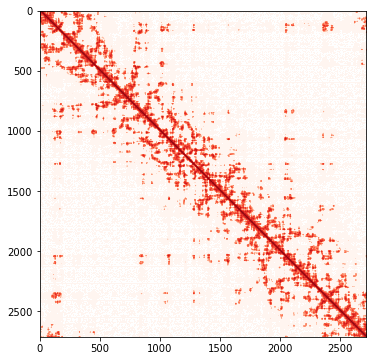

In [14]:
fig=plt.figure(figsize=(6,6))
plt.imshow(ahic, norm=LogNorm(vmin=1e-4,vmax=1), cmap='Reds')